# Projekt: klasyfikacja gatunku utworu muzycznego na podstawie nagrania audio

## Dataset

GTZAN - zbiór tysiąca 30 sekundowych nagrań audio utworów muzycznych z 10 gatunków.

## Co ma powiedzieć analiza danych
Jakie wspólne cechy mają utwory muzyczne z tego samego gatunku?

## Plan
- EDA
- Feature engineering
- Porównanie poznanych na wykładzie modeli do klasyfikacji
- Zastosowanie metod machine learning'u, które pojawiły się na ćwiczeniach (np. wykrywanie outlier'ów, feature selection)
- Różne pomysły, które przyjdą nam do głowy (np. sprawdzanie jak modele radzą sobie z zaszumioną muzyką, albo czy dane z 3 sekundowego utworu wystarczą do klasyfikacji)
- klasteryzacja w gatunkach, żeby zobaczyć jakie są typowe osobniki
- knn na chroma
- gdzie model się myli

## Co trza najpierw zrobić
- pipeline preprocessingu danych

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv("Data/features_30_sec.csv")
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

In [3]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [4]:
ipd.Audio('Data/genres_original/pop/pop.00012.wav')

In [5]:
genres = df['label'].unique()

In [6]:
files_by_genre = {g: list(df[df['label'] == g]['filename']) for g in genres}

In [7]:
audio_paths = [f'Data/genres_original/{g}/{g}.00000.wav' for g in genres]
audio_paths

['Data/genres_original/blues/blues.00000.wav',
 'Data/genres_original/classical/classical.00000.wav',
 'Data/genres_original/country/country.00000.wav',
 'Data/genres_original/disco/disco.00000.wav',
 'Data/genres_original/hiphop/hiphop.00000.wav',
 'Data/genres_original/jazz/jazz.00000.wav',
 'Data/genres_original/metal/metal.00000.wav',
 'Data/genres_original/pop/pop.00000.wav',
 'Data/genres_original/reggae/reggae.00000.wav',
 'Data/genres_original/rock/rock.00000.wav']

# Helper functions

In [8]:
def full_filename_from_path(path):
    g = path.split('.')[0]
    return f'Data/genres_original/{g}/{path}'

In [9]:
def visualize_feature(audio_path, librosa_fun, ax, y_label):
    y, sr = librosa.load(audio_path, sr=None)
    
    features = librosa_fun(y, sr)
    
    img = librosa.display.specshow(
        features, 
        sr=sr,
        x_axis='time', 
        ax=ax,
    )
    
    audio_title = audio_path.split('/')[-1]
    ax.set_title(f'{audio_title}', pad=10)
    ax.set_ylabel(y_label, fontsize=9)

    return img

def visualize_feature_no_colorbar(audio_path, librosa_fun, ax, y_label):
    y, sr = librosa.load(audio_path, sr=None)

    features = librosa_fun(y, sr)
    
    times = librosa.times_like(features, sr=sr)
    
    sns.lineplot(x=times, y=features[0], ax=ax)
    
    audio_title = audio_path.split('/')[-1]
    ax.set_title(f'{audio_title}', pad=10)
    ax.set_ylabel(y_label, fontsize=9)

    return None


def visualize_feature_from_every_genre(librosa_fun, suptitle, y_label, legend_label, vis_feat=None, use_colorbar=True):
    """
    fun - function from librosa that takes y and sr and returns desired feature
    suptitle - title for the whole graph
    y_label - label for y axis
    legend_label - label for legend
    """
    fg, axs = plt.subplots(len(audio_paths), 1, figsize=(15, 30))
    
    for i, ap in enumerate(audio_paths):
        if use_colorbar:
            img = visualize_feature(ap, librosa_fun, axs[i], y_label)
        else:
            img = visualize_feature_no_colorbar(ap, librosa_fun, axs[i], y_label)
    
    fg.subplots_adjust(hspace=0.6, right=0.88)
    fg.suptitle(suptitle, fontsize=16, y=0.91)
    
    for ax in axs[:-1]:
        ax.set_xlabel("")

    if use_colorbar:
        cbar_ax = fg.add_axes([0.9, 0.70, 0.02, 0.15])
        fg.colorbar(img, cax=cbar_ax)
        cbar_ax.set_ylabel(legend_label, fontsize=10)

# Tempo

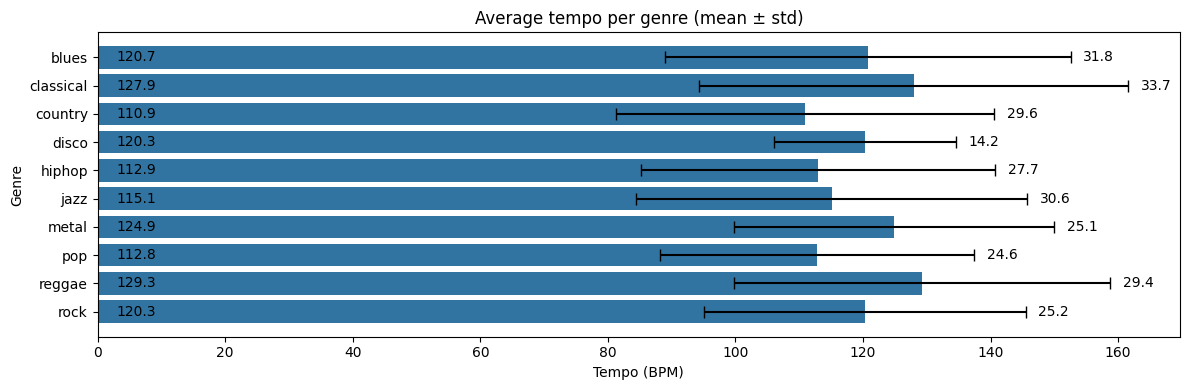

In [10]:
tempo_data = df.groupby("label")["tempo"].agg(mean="mean", std="std").reset_index()

plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=tempo_data,
    x="mean",
    y="label",
    errorbar=None,
)

ax.errorbar(
    x=tempo_data["mean"],
    y=range(len(tempo_data)),
    xerr=tempo_data["std"],
    fmt="none",
    c="black",
    capsize=4
)

ax.set_xlabel("Tempo (BPM)")
ax.set_ylabel("Genre")
ax.set_title("Average tempo per genre (mean ± std)")

# labels for mean
for i, row in enumerate(tempo_data['mean']):
    ax.text(
        3,
        i,
        f"{row:.1f}",
        va="center"
    )

# labels for std
for i, (mean_val, std_val) in enumerate(zip(tempo_data['mean'], tempo_data['std'])):
    ax.text(
        mean_val + std_val + 2,
        i,
        f"{std_val:.1f}",
        va="center"
    )

plt.tight_layout()
plt.show()


# Mel-frequency cepstral coefficients (MFCCs)

Poniżej przedstawiam wizualizację [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), czyli współczynników, które składają się na reprezentację pewnego spektrum dźwięku (TODO: zrobić opis, który faktycznie coś tłumaczy)


- Współczynnik ma dodatnie wartości -> większość energii spektralnej jest w regionach o niskiej częstotliwości
- Współczynnik ma ujemne wartości -> większość energii jest jest w wysokich częstotliwościach

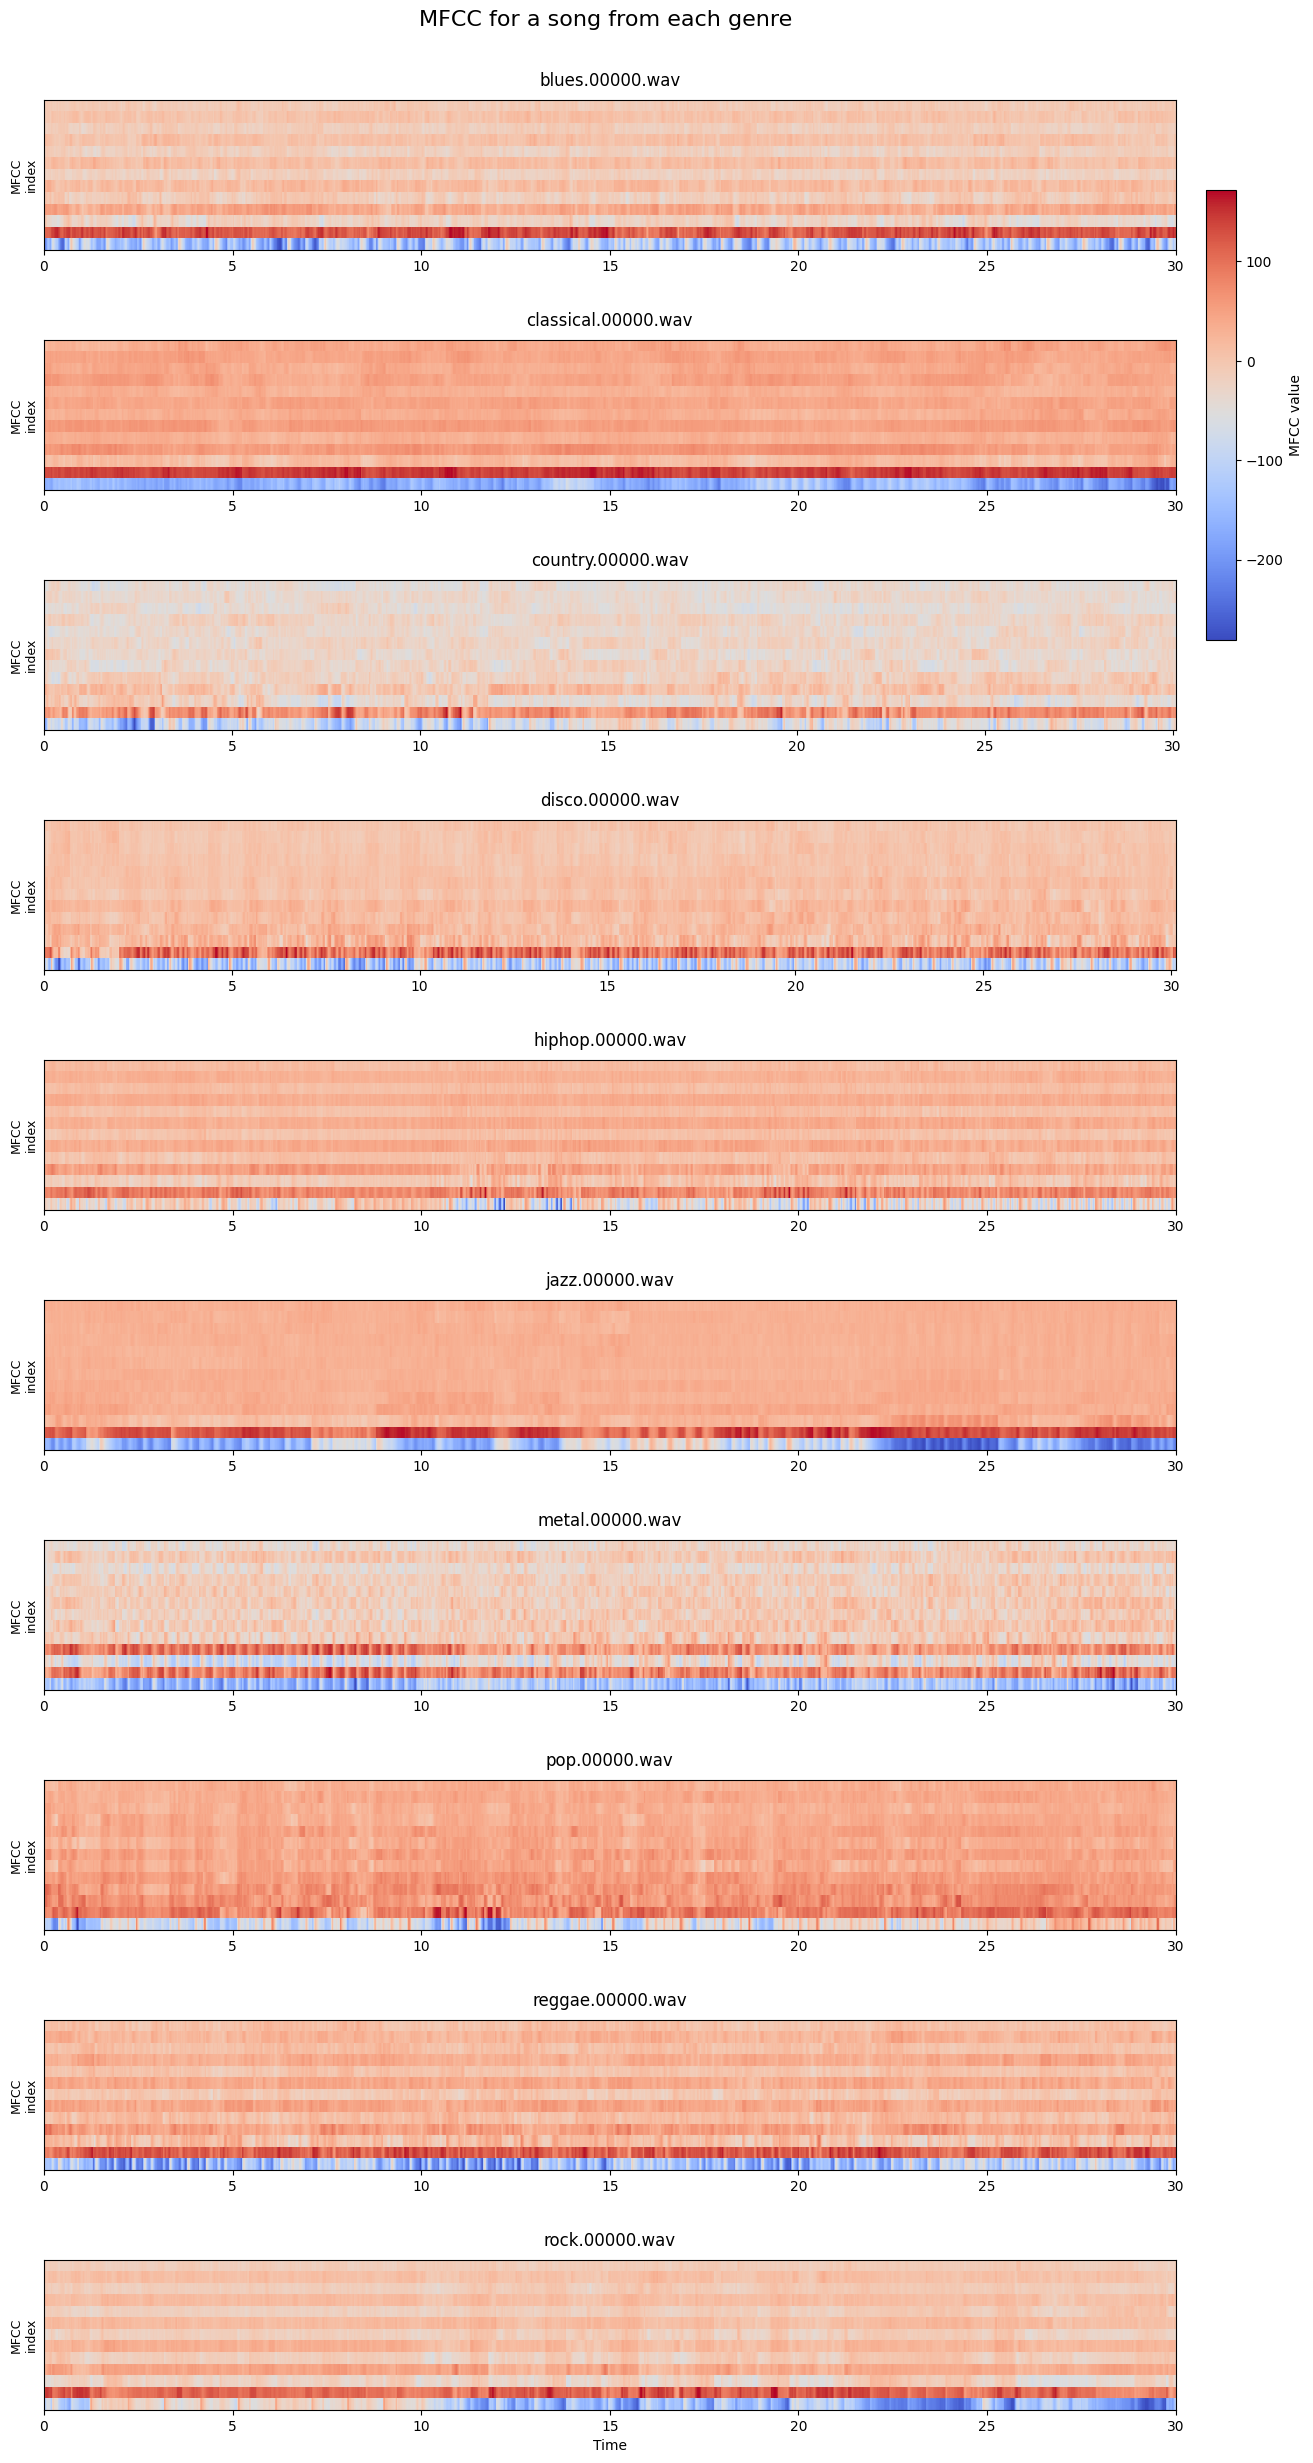

In [11]:
visualize_feature_from_every_genre(
    lambda y, sr: librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),
    "MFCC for a song from each genre",
    "MFCC\nindex",
    "MFCC value",
)

# Chroma

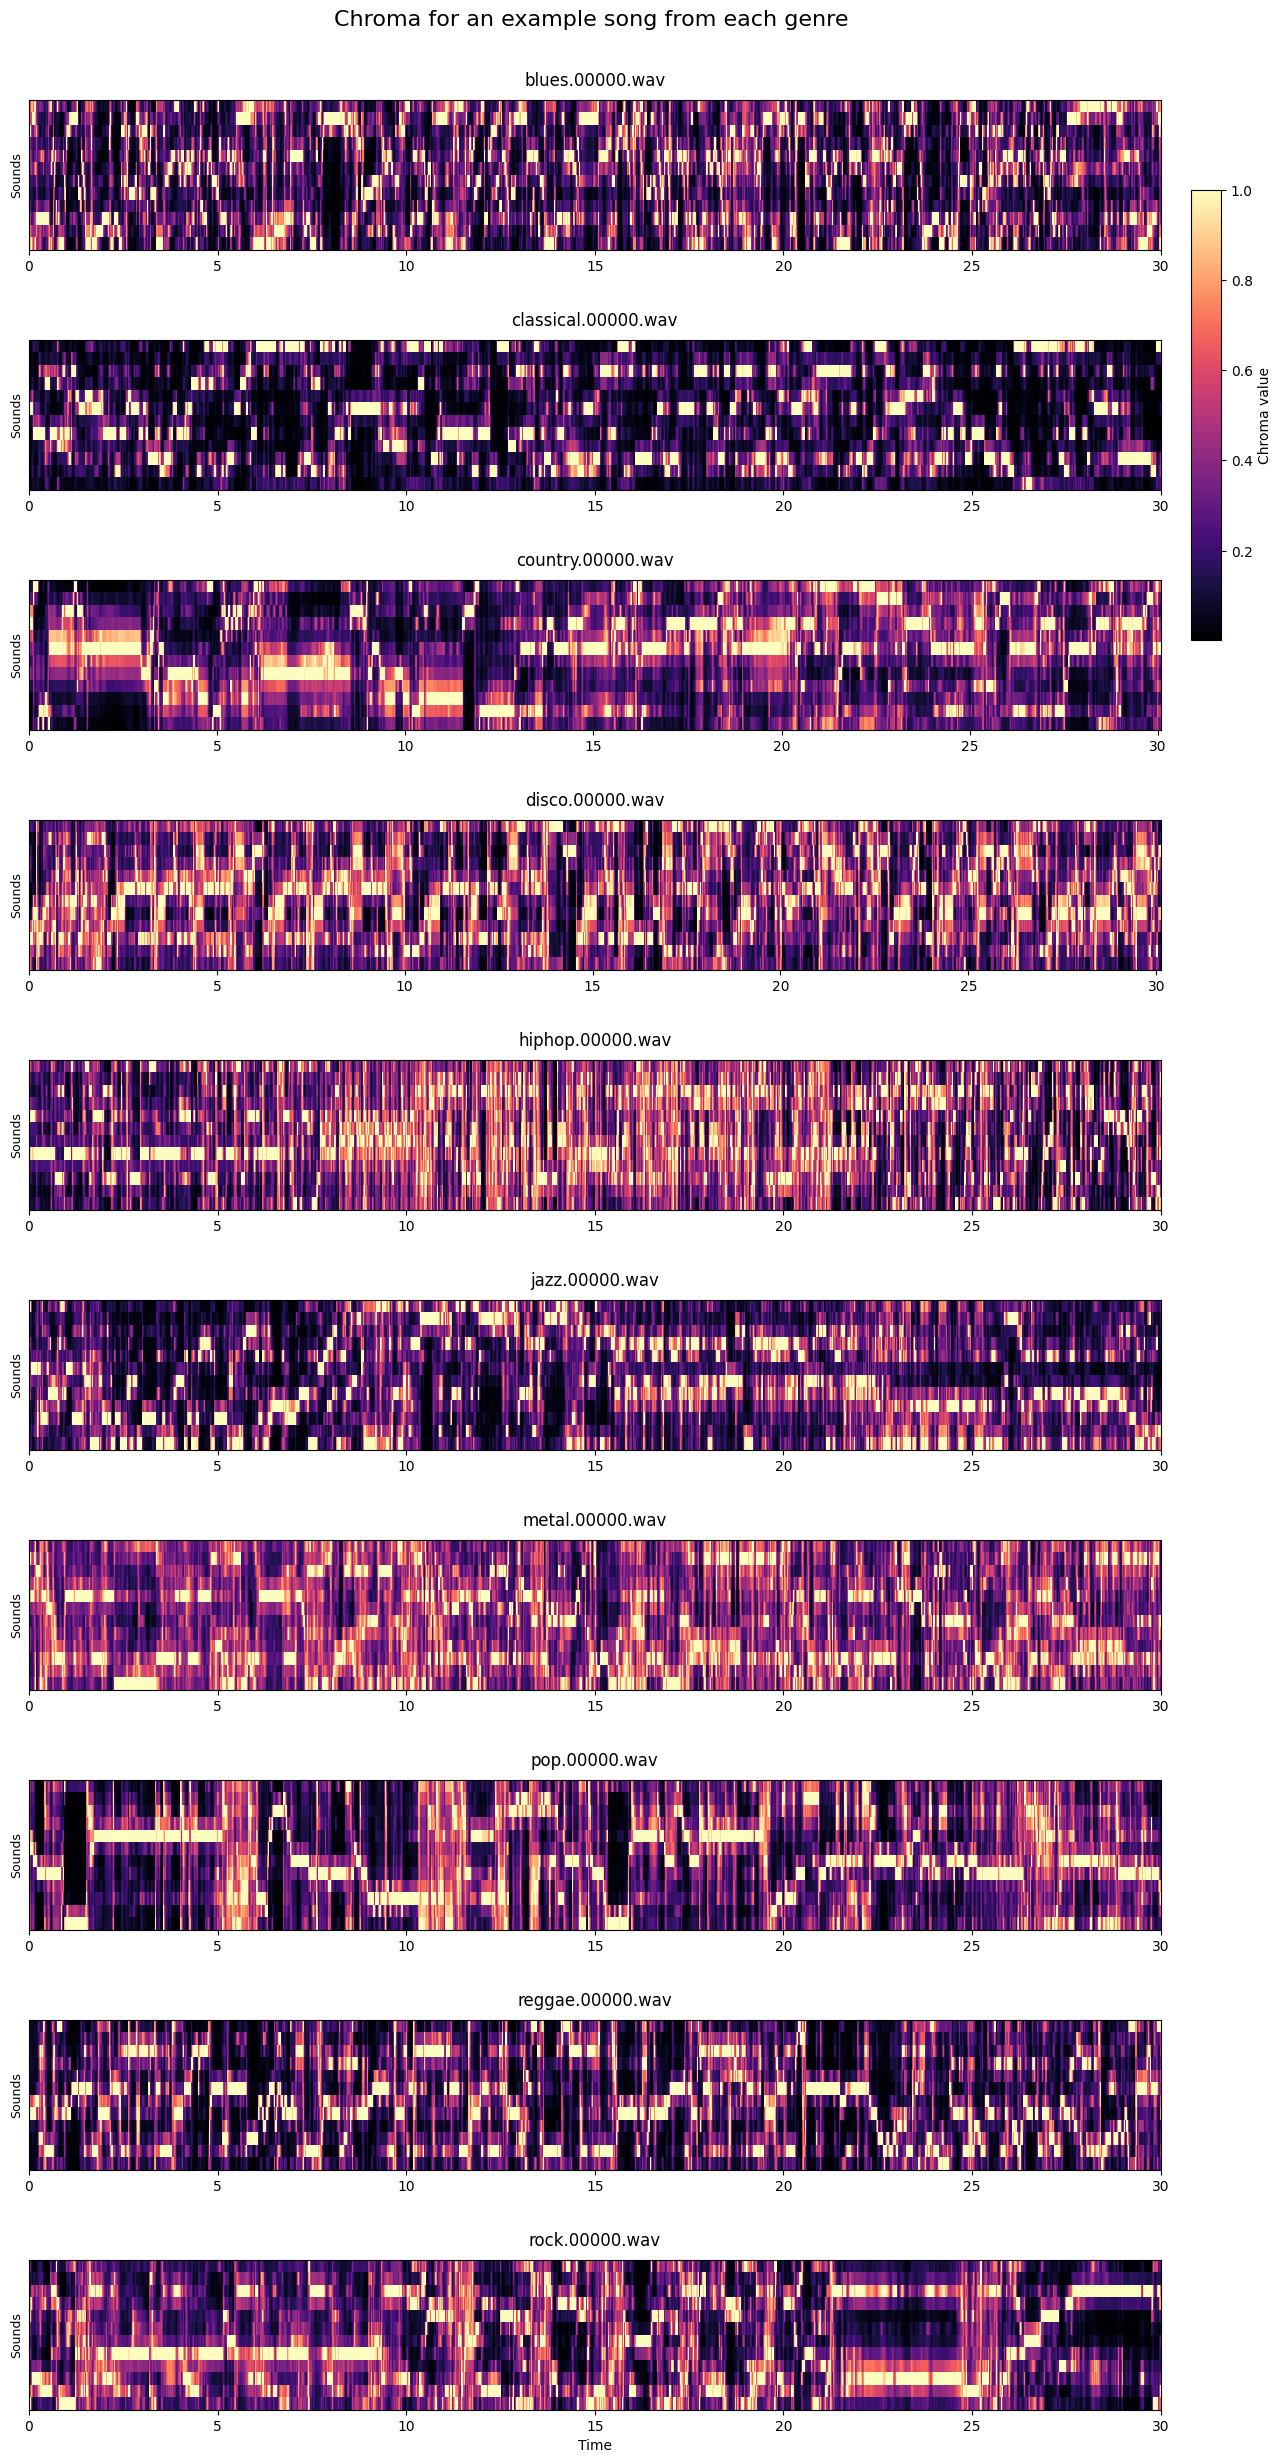

In [12]:
visualize_feature_from_every_genre(
    lambda y, sr: librosa.feature.chroma_stft(y=y, sr=sr),
    "Chroma for an example song from each genre",
    'Sounds',
    "Chroma value",
)

In [13]:
def get_chroma(audio_path):
    try:
        path = full_filename_from_path(audio_path)
        y, sr = librosa.load(path)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        return chroma
    except Exception as e:
        print(f'failed for file: {audio_path}')
        return None

jazz_chromas = [get_chroma(path) for path in files_by_genre['jazz']]
jazz_chromas = [c for c in jazz_chromas if c is not None]

/tmp/ipykernel_155747/1411333664.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path)
/home/adziw/Uni/venv_ai/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


failed for file: jazz.00054.wav


# RMS - Root mean square energy

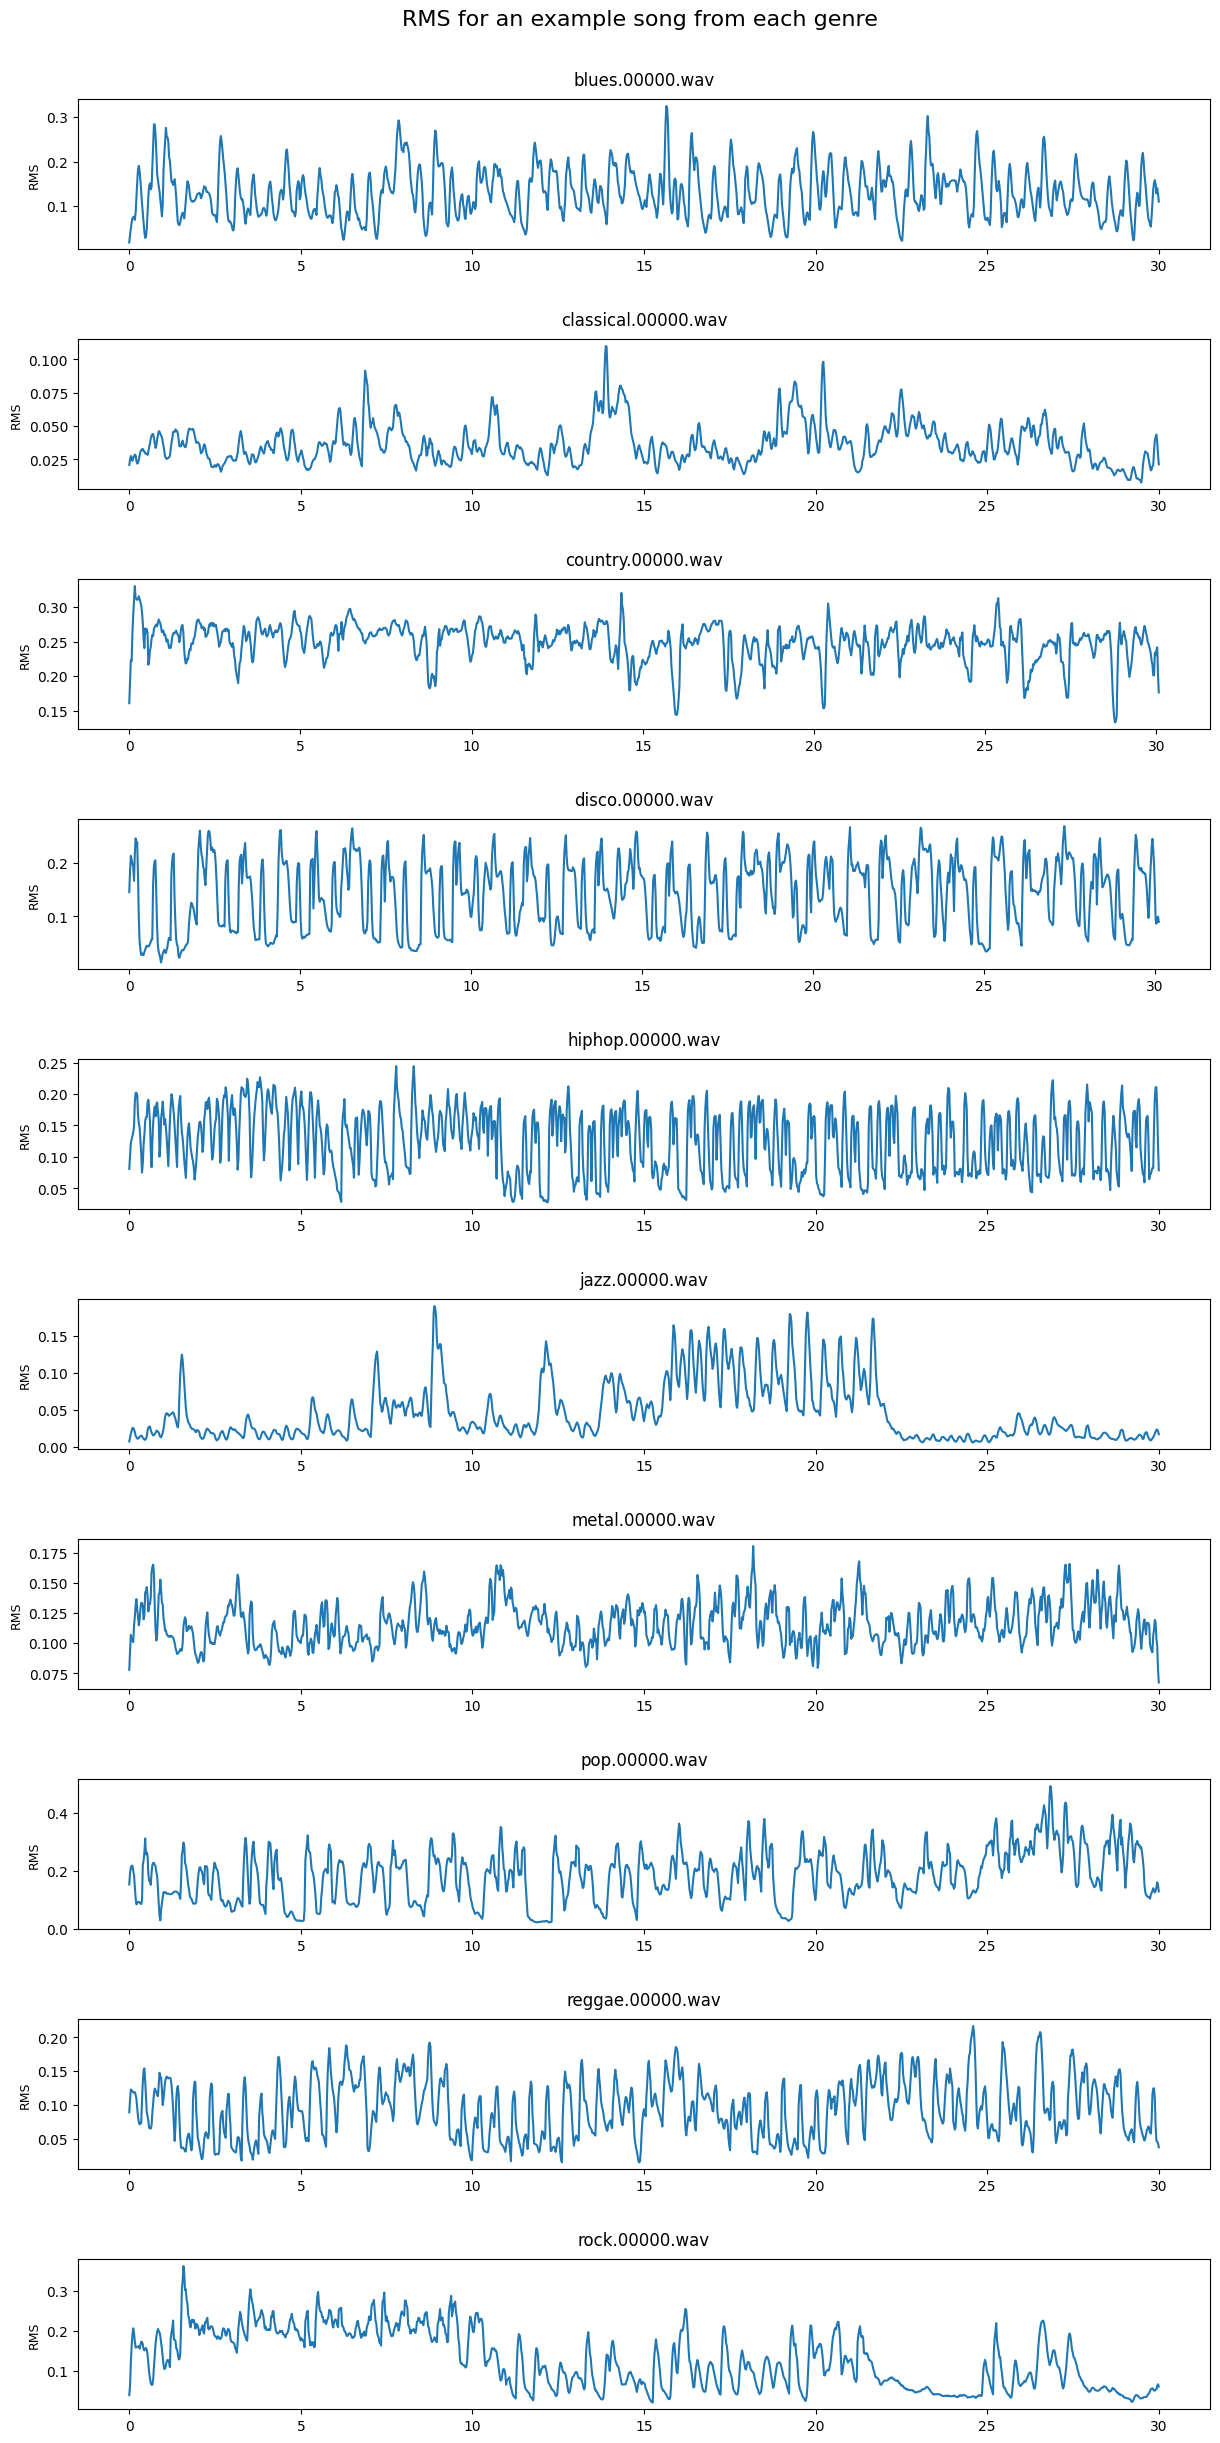

In [14]:
visualize_feature_from_every_genre(
    lambda y, sr: librosa.feature.rms(y=y),
    "RMS for an example song from each genre",
    'RMS',
    None,
    use_colorbar=False
)

# Zero crossing rate

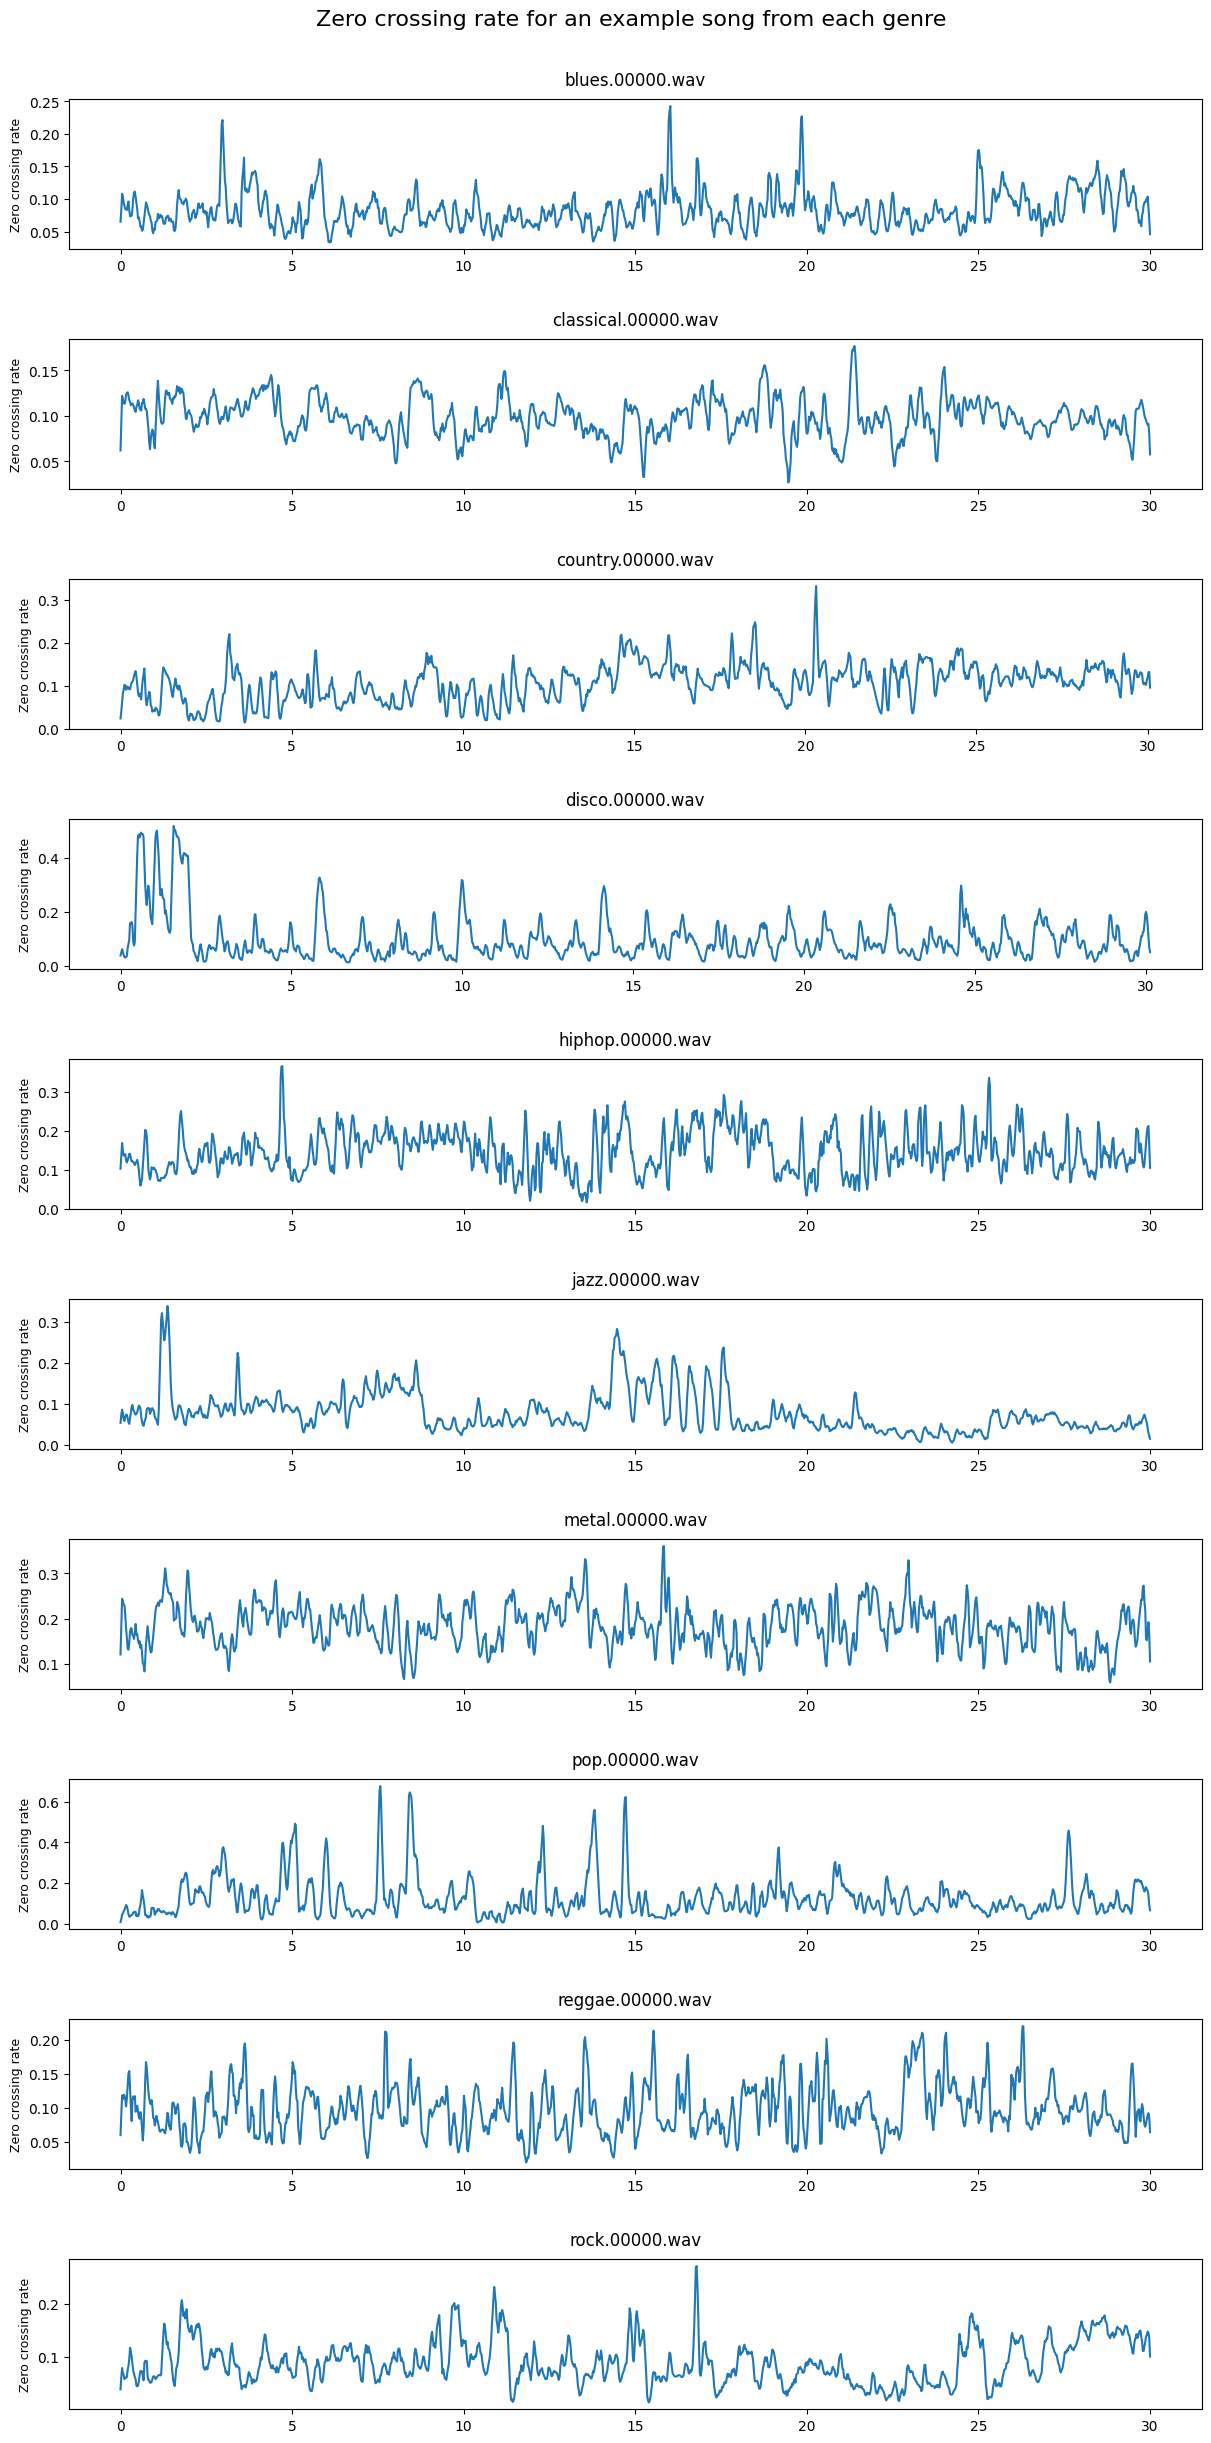

In [15]:
visualize_feature_from_every_genre(
    lambda y, sr: librosa.feature.zero_crossing_rate(y=y),
    "Zero crossing rate for an example song from each genre",
    'Zero crossing rate',
    None,
    use_colorbar=False
)

# Spectral centroid

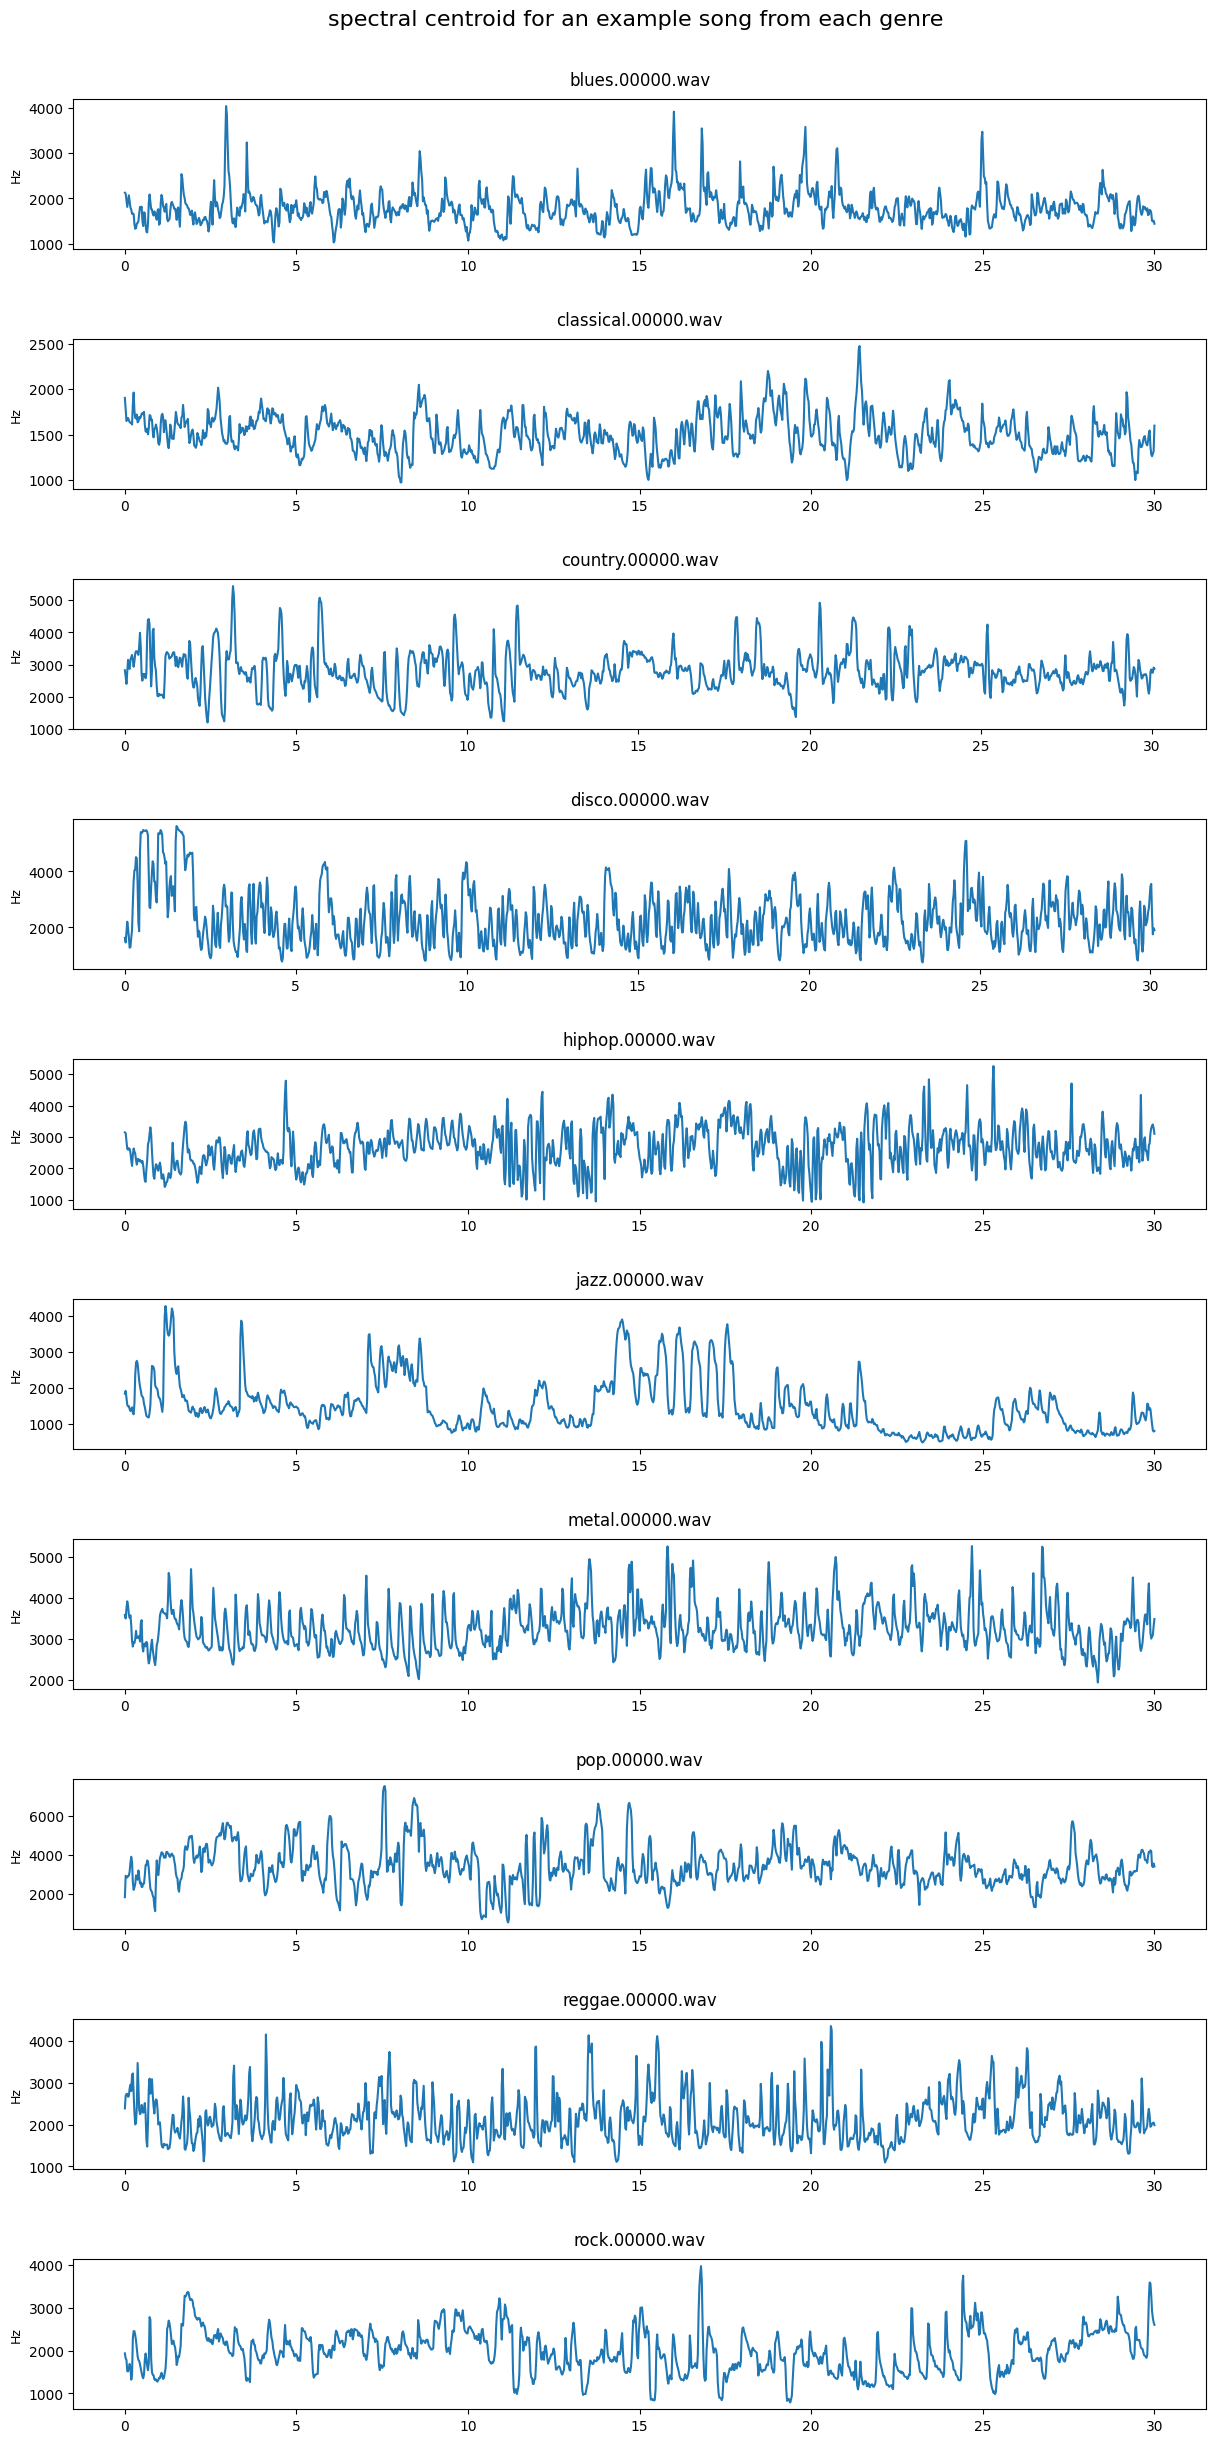

In [16]:
visualize_feature_from_every_genre(
    lambda y, sr: librosa.feature.spectral_centroid(y=y, sr=sr),
    "spectral centroid for an example song from each genre",
    'Hz',
    None,
    use_colorbar=False
)

# Spectral bandwidth

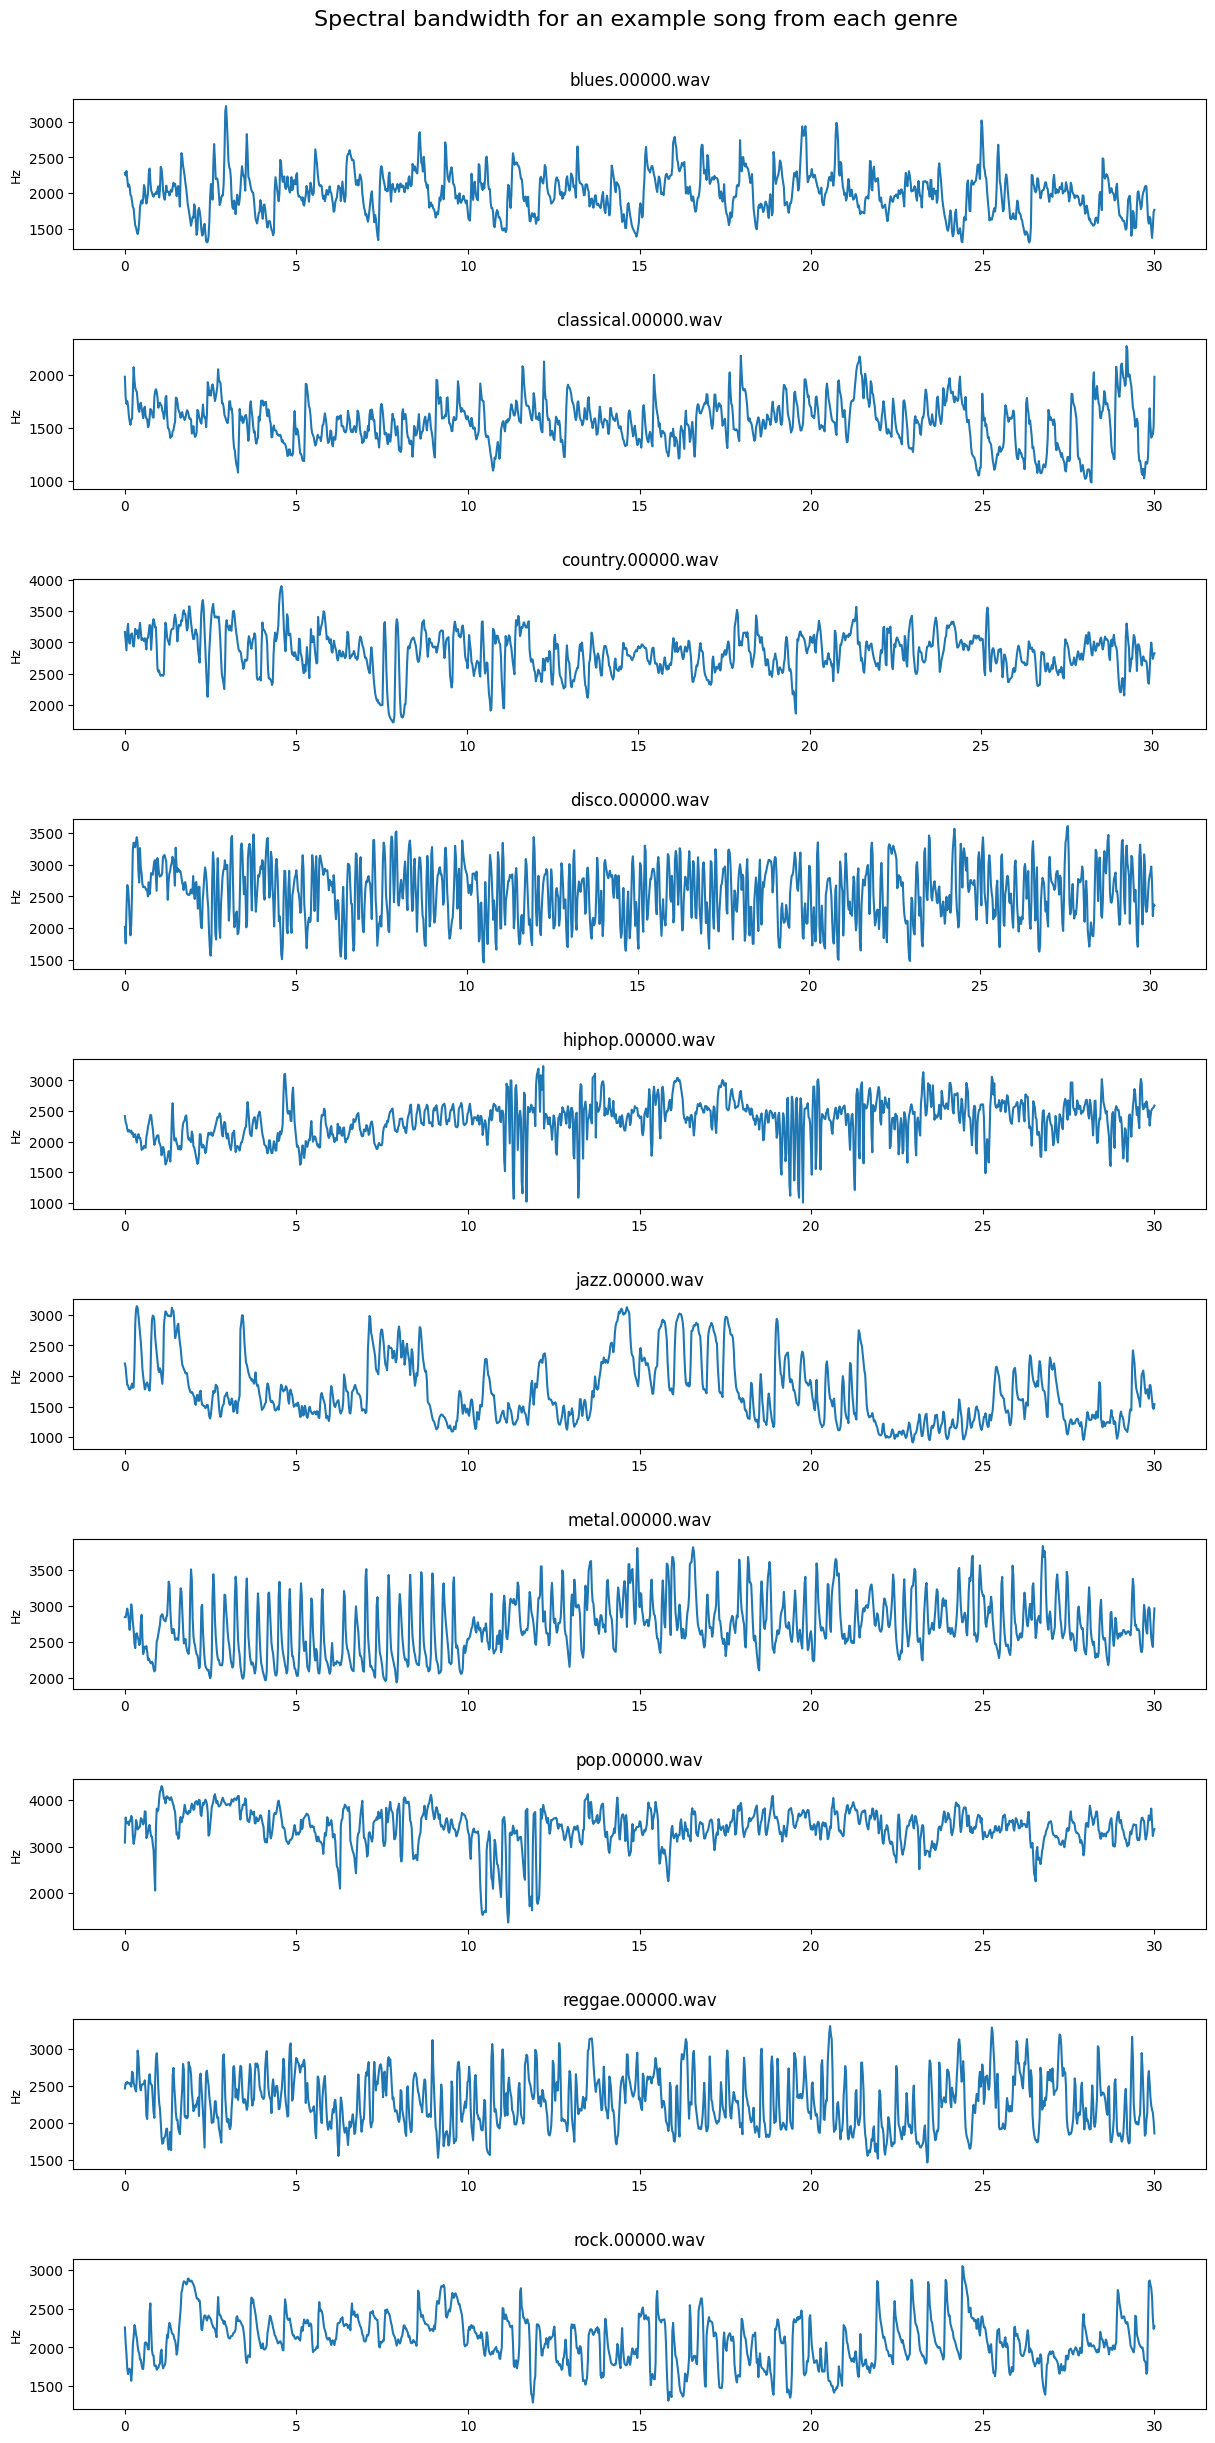

In [17]:
visualize_feature_from_every_genre(
    lambda y, sr: librosa.feature.spectral_bandwidth(y=y, sr=sr),
    "Spectral bandwidth for an example song from each genre",
    'Hz',
    None,
    use_colorbar=False
)

# Rolloff

# Harmony

# Perceptr

# Baseline model

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

In [19]:
X, y = df.drop(['filename', 'length', 'label'], axis=1), df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
model = svm.SVC()
model.fit(X_train, y_train)

SVC()

In [21]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Baseline model accuracy = {acc:0.2f}')

Baseline model accuracy = 0.21
